## Imports Management

In [1]:
!pip install -q pytorch-lightning umap-learn

     |████████████████████████████████| 796 kB 14.6 MB/s 
     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 529 kB 51.3 MB/s 
     |████████████████████████████████| 136 kB 39.0 MB/s 
     |████████████████████████████████| 87 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import RandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import sklearn.cluster as cluster
import pandas as pd
import numpy as np
import umap

## Download Data

In [3]:
mnist_train, mnist_val = random_split(
    MNIST("content/mnist_dat", train = True, download = True, transform = transforms.ToTensor()), 
    [50000, 10000]
)
mnist_test = MNIST("content/mnist_dat", train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting content/mnist_dat/MNIST/raw/train-images-idx3-ubyte.gz to content/mnist_dat/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting content/mnist_dat/MNIST/raw/train-labels-idx1-ubyte.gz to content/mnist_dat/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting content/mnist_dat/MNIST/raw/t10k-images-idx3-ubyte.gz to content/mnist_dat/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting content/mnist_dat/MNIST/raw/t10k-labels-idx1-ubyte.gz to content/mnist_dat/MNIST/raw



In [4]:
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size = batch_size)
val_loader = DataLoader(mnist_val, batch_size = batch_size)
test_loader = DataLoader(mnist_test)

## Visualising the data

Target : 1


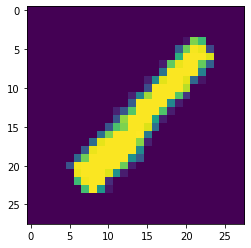

Target : 1


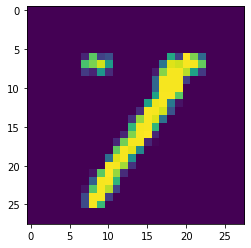

Target : 9


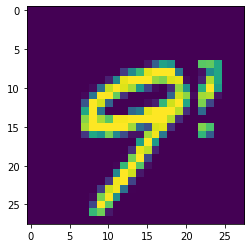

Target : 5


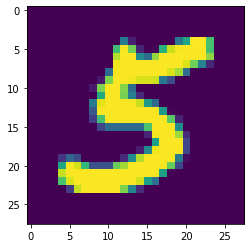

Target : 4


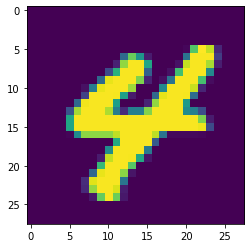

Target : 6


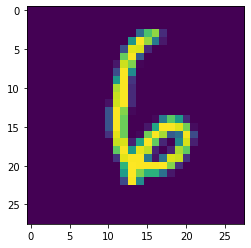

Target : 6


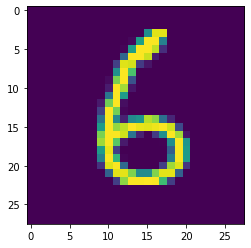

Target : 0


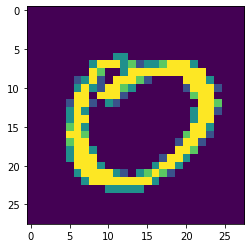

Target : 9


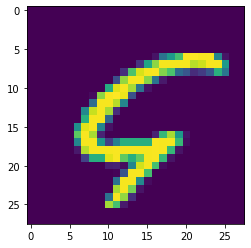

Target : 6


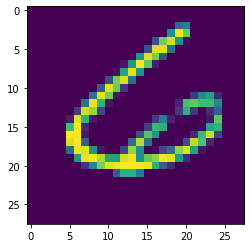

In [5]:
for i in RandomSampler(data_source = mnist_train, num_samples=10):
    print("==============================")
    print(f"Target : {mnist_train[i][1]}")
    plt.imshow(mnist_train[i][0].view(28, 28))
    plt.show()

## Set up Autoencoder

In [6]:
class MNISTAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Linear(64, 28*28),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        return z
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss" , loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("val_loss" , loss)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("test_loss" , loss)
        return loss
    
    def generate(self, z):
        return self.decoder(z)
    
    def backward(self, loss, optimizer,  optimizer_idx):
        loss.backward()


In [7]:
AE_model = MNISTAutoEncoder()
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
trainer = pl.Trainer(accelerator="cpu", max_epochs = 50, check_val_every_n_epoch=1, callbacks=[early_stop_callback])
trainer.fit(AE_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
trainer.test(AE_model, test_loader)

Testing: 0it [00:00, ?it/s]

In [9]:
out = {"z1":[], "z2":[], "y":[]}
for x, y in test_loader:
    z = AE_model(x).detach().numpy()[0]
    out["z1"].append(z[0])
    out["z2"].append(z[1])
    out["y"].append(y)
test_res_ae = pd.DataFrame.from_dict(out)

In [10]:
sampled_pts = torch.FloatTensor(1, 2).uniform_(-1, 1)

## Latent Space Visualisation

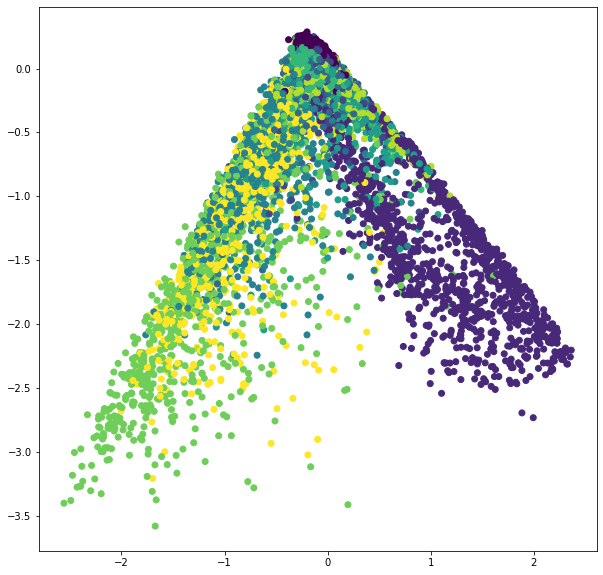

In [11]:
plt.figure(figsize = (10, 10))
plt.scatter(test_res_ae.z1, test_res_ae.z2, c = test_res_ae.y)

## Generative Modelling

tensor([ 0.2697, -0.3328])


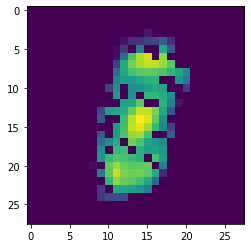

In [12]:
for i, val in enumerate(AE_model.generate(sampled_pts)):
    print(sampled_pts[i])
    val = val.view(28, 28)
    plt.imshow(val.detach())
    plt.show()
    print("==========================")

# Variational Autoencoder

In [13]:
class MNISTVarAutoEncoder(pl.LightningModule):
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.mu = nn.Sequential(
            nn.Linear(64,2),
        )

        self.sigma = nn.Sequential(
            nn.Linear(64,2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Linear(64, 28*28),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def reparam(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        z_mu = self.mu(z)
        z_sigma = self.sigma(z)
        z_rep = self.reparam(z_mu, z_sigma)
        return z_mu
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)

        z = self.encoder(x)
        z_mu = self.mu(z)
        z_sigma = self.sigma(z)
        z_rep = self.reparam(z_mu, z_sigma)

        x_hat = self.decoder(z_rep)

        recon_loss = F.mse_loss(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - z_sigma.exp())

        loss = recon_loss + self.beta*kl_loss
        self.log("train_loss" , loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)

        z = self.encoder(x)
        z_mu = self.mu(z)
        z_sigma = self.sigma(z)
        z_rep = self.reparam(z_mu, z_sigma)

        x_hat = self.decoder(z_rep)

        recon_loss = F.mse_loss(x_hat, x)
        kl_loss = -0.5 * torch.mean(1 + z_sigma - z_mu.pow(2) - z_sigma.exp())

        loss = recon_loss + self.beta*kl_loss
        self.log("val_loss" , loss)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        x = x.view(x.size(0), -1)

        z = self.encoder(x)
        z_mu = self.mu(z)
        z_sigma = self.sigma(z)
        z_rep = self.reparam(z_mu, z_sigma)

        x_hat = self.decoder(z_rep)

        recon_loss = F.mse_loss(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - z_sigma.exp())

        loss = recon_loss + self.beta*kl_loss
        self.log("test_loss" , loss)
        return loss
    
    def generate(self, z):
        return self.decoder(z)
    
    def backward(self, loss, optimizer,  optimizer_idx):
        loss.backward()


In [15]:
VAE_model = MNISTVarAutoEncoder(5e-5)
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
trainer = pl.Trainer(accelerator="gpu", max_epochs = 50, check_val_every_n_epoch=1, callbacks=[early_stop_callback])
trainer.fit(VAE_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.2 K
1 | mu      | Sequential | 130   
2 | sigma   | Sequential | 130   
3 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
trainer.test(VAE_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.061608899384737015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.061608899384737015}]

In [17]:
out = {"z1":[], "z2":[], "y":[]}
for x, y in test_loader:
    z = VAE_model(x).detach().numpy()[0]
    out["z1"].append(z[0])
    out["z2"].append(z[1])
    out["y"].append(y)
test_res = pd.DataFrame.from_dict(out)

## Latent space visualization

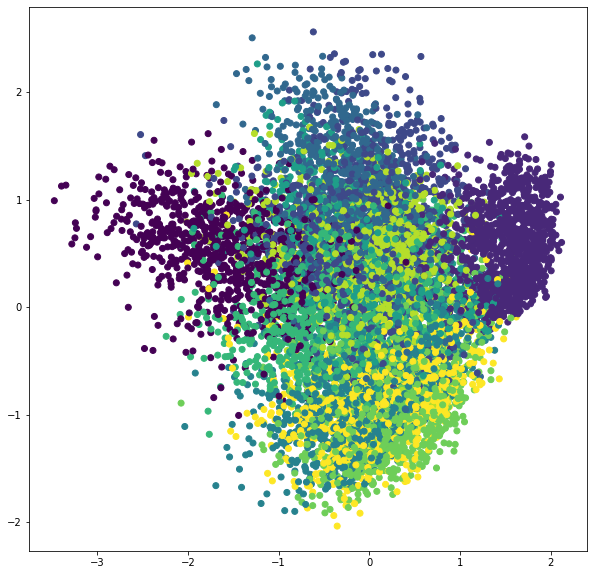

In [18]:
plt.figure(figsize = (10, 10))
plt.scatter(test_res.z1, test_res.z2, c = test_res.y)

tensor([ 0.2697, -0.3328])


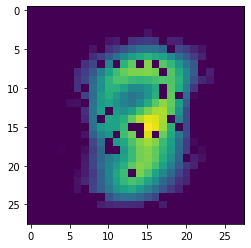

In [19]:
for i, val in enumerate(VAE_model.generate(sampled_pts)):
    print(sampled_pts[i])
    val = val.view(28, 28)
    plt.imshow(val.detach())
    plt.show()
    print("==========================")

## Other Values of Weight on KL

In [20]:
VAE_model = MNISTVarAutoEncoder(1e-8)
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
trainer = pl.Trainer(accelerator="gpu", max_epochs = 50, check_val_every_n_epoch=1, callbacks=[early_stop_callback])
trainer.fit(VAE_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.2 K
1 | mu      | Sequential | 130   
2 | sigma   | Sequential | 130   
3 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
trainer.test(VAE_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05828806757926941
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05828806757926941}]

In [22]:
out = {"z1":[], "z2":[], "y":[]}
for x, y in test_loader:
    z = VAE_model(x).detach().numpy()[0]
    out["z1"].append(z[0])
    out["z2"].append(z[1])
    out["y"].append(y)
test_res = pd.DataFrame.from_dict(out)

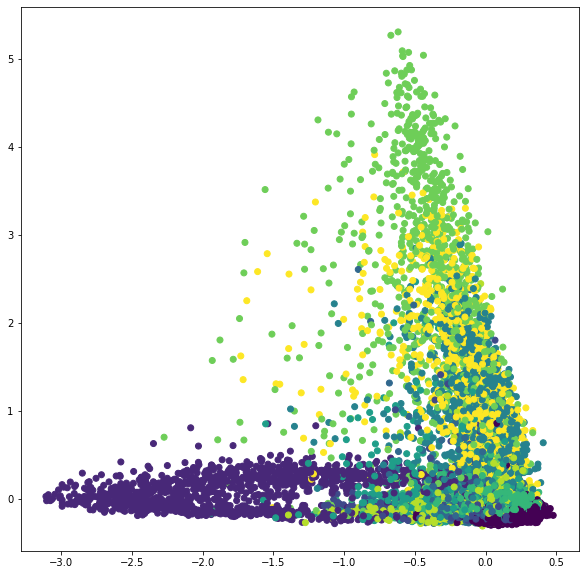

In [23]:
plt.figure(figsize = (10, 10))
plt.scatter(test_res.z1, test_res.z2, c = test_res.y)

tensor([ 0.2697, -0.3328])


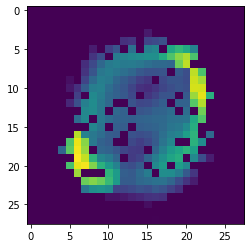

In [24]:
for i, val in enumerate(VAE_model.generate(sampled_pts)):
    print(sampled_pts[i])
    val = val.view(28, 28)
    plt.imshow(val.detach())
    plt.show()
    print("==========================")

In [30]:
VAE_model = MNISTVarAutoEncoder(8e-4)
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
trainer = pl.Trainer(accelerator="gpu", max_epochs = 50, check_val_every_n_epoch=1, callbacks=[early_stop_callback])
trainer.fit(VAE_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.2 K
1 | mu      | Sequential | 130   
2 | sigma   | Sequential | 130   
3 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [31]:
trainer.test(VAE_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.06846163421869278
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06846163421869278}]

In [32]:
out = {"z1":[], "z2":[], "y":[]}
for x, y in test_loader:
    z = VAE_model(x).detach().numpy()[0]
    out["z1"].append(z[0])
    out["z2"].append(z[1])
    out["y"].append(y)
test_res = pd.DataFrame.from_dict(out)

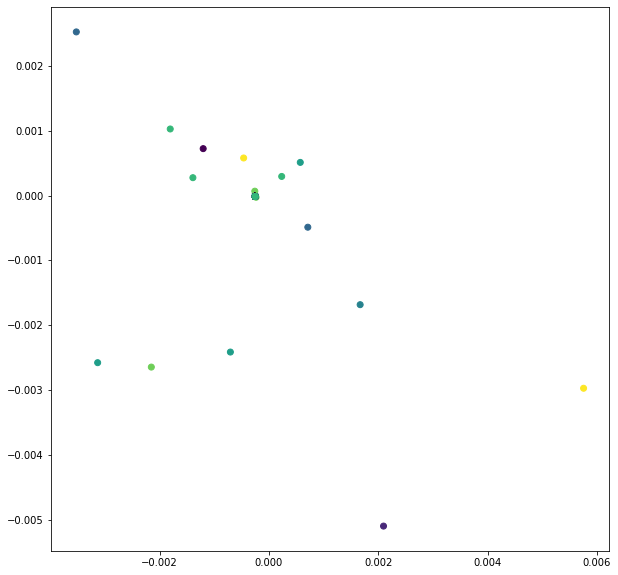

In [33]:
plt.figure(figsize = (10, 10))
plt.scatter(test_res.z1, test_res.z2, c = test_res.y)

tensor([ 0.2697, -0.3328])


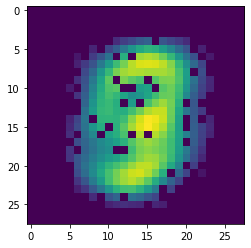

In [34]:
for i, val in enumerate(VAE_model.generate(sampled_pts)):
    print(sampled_pts[i])
    val = val.view(28, 28)
    plt.imshow(val.detach())
    plt.show()
    print("==========================")